In [1]:
import numpy as np
import time

from romgw.config.env import PROJECT_ROOT
from romgw.model.core import ModeROM, ROMGW
from romgw.waveform.base import FullWaveform
from romgw.waveform.dataset import FullWaveformDataset
from romgw.waveform.params import PhysicalParams

In [2]:
bbh_spin = "NS"
mode = "2,2"
model_name = "NonLinRegV1"

In [3]:
mode_model = ModeROM(bbh_spin, mode, model_name)
# print(f"{mode_model=}")
romgw_model = ROMGW(bbh_spin, model_name)
# print(f"{romgw_model=}")

In [4]:
test_param_space_file = (PROJECT_ROOT / "data" / bbh_spin / "test" /
                             "parameter_space.npy")
X_raw = np.load(test_param_space_file, allow_pickle=False)

if bbh_spin == "NS":
    X_arr = X_raw[:, :1]
else:
    X_arr = X_raw[:, :]

if bbh_spin == "NS":
    params_list = [PhysicalParams(*arr, 0.0, 0.0) for arr in X_arr]
elif bbh_spin == "AS":
    params_list = [PhysicalParams(*arr) for arr in X_arr]
else:  # if bbh_spin == "PS"
    params_list = [PhysicalParams(arr[0], arr[1:4], arr[4:7]) for arr in X_arr]
    
M = len(params_list)

In [5]:
# # ----- Individual waveform mode generation -----
# waveforms = [] ; i = 0 ; t_elapsed = 0
# for i in range(M):
#     print(f"Generating waveform "
#           f"{i+1:0{len(str(len(X_arr) - 1))}d}/{len(X_arr)}",
#           end='\r')
    
#     params_arr, params = X_arr[i], params_list[i]

#     t_start = time.perf_counter()
#     # ----- Time this -----
#     wf_arr = mode_model.generate_mode(params_arr)
#     # ---------------------
#     t_finish = time.perf_counter()
#     t_i = t_finish - t_start
#     t_elapsed += t_i
    
#     wf = FullWaveform(wf_arr, params)
#     waveforms.append(wf)

# print(f"Took {t_elapsed:.6f}s to generate {M} ROMGW {mode} waveform modes\n"
#       f">>> {t_elapsed / M:.6f}s per waveform (mean)")

# romgw_waveforms = FullWaveformDataset(waveforms)
# print(f"{romgw_waveforms=}")

In [15]:
# ----- Vectorised waveform mode generation -----
t_start = time.perf_counter()
# ----- Time this -----
# waveforms_arr = mode_model.generate_mode_vectorised(X_arr)
waveforms_arr = mode_model.generate_mode_generalised(X_arr)
# ---------------------
t_finish = time.perf_counter()
t_elapsed = t_finish - t_start

print(f"Took {t_elapsed:.6f}s to generate {M} ROMGW {mode} waveform modes\n"
      f">>> {t_elapsed / M:.6f}s per waveform (mean)")

waveforms = [FullWaveform(waveforms_arr[i], params_list[i]) for i in range(M)]
romgw_waveforms = FullWaveformDataset(waveforms)
print(f"{romgw_waveforms=}")

Took 0.293331s to generate 256 ROMGW 2,2 waveform modes
>>> 0.001146s per waveform (mean)
romgw_waveforms=<FullWaveformDataset(n=256, L=5250)>


In [7]:
# # ----- Individual waveform generation -----
# modes_list = [] ; i = 0 ; t_elapsed = 0
# for i in range(M):
#     print(f"Generating modes "
#           f"{i+1:0{len(str(len(X_arr) - 1))}d}/{len(X_arr)}",
#           end='\r')
    
#     params_arr, params = X_arr[i], params_list[i]

#     t_start = time.perf_counter()
#     # ----- Time this -----
#     modes_arrays = romgw_model.generate_modes(params_arr)
#     # ---------------------
#     t_finish = time.perf_counter()
#     t_i = t_finish - t_start
#     t_elapsed += t_i
    
#     modes = {m: FullWaveform(wf_arr, params)
#              for m, wf_arr in modes_arrays.items()}
#     modes_list.append(modes)

# print(f"Took {t_elapsed:.6f}s to generate {M} "
#       f"complete ROMGW waveform mode sets "
#       f"({list(romgw_model.mode_models.keys())})\n"
#       f">>> {t_elapsed / M:.6f}s per complete waveform mode set (mean)")

In [ ]:
# ----- Vectorised waveform generation -----
t_start = time.perf_counter()
# ----- Time this -----
# modes_list = romgw_model.generate_modes_vectorised(X_arr)
modes_list = romgw_model.generate_modes_generalised(X_arr)
# ---------------------
t_finish = time.perf_counter()
t_elapsed = t_finish - t_start

print(f"Took {t_elapsed:.6f}s to generate {M} "
      f"complete ROMGW waveform mode sets "
      f"({list(romgw_model.mode_models.keys())})\n"
      f">>> {t_elapsed / M:.6f}s per complete waveform mode set (mean)")

In [9]:
fiducial_wf_dir = PROJECT_ROOT / "data" / bbh_spin / "test" / mode / "full" / "raw"
fiducial_waveforms = FullWaveformDataset.from_directory(fiducial_wf_dir)

Waveforms loaded.                                                               


In [10]:
from romgw.plotting.core import plot_mismatch

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


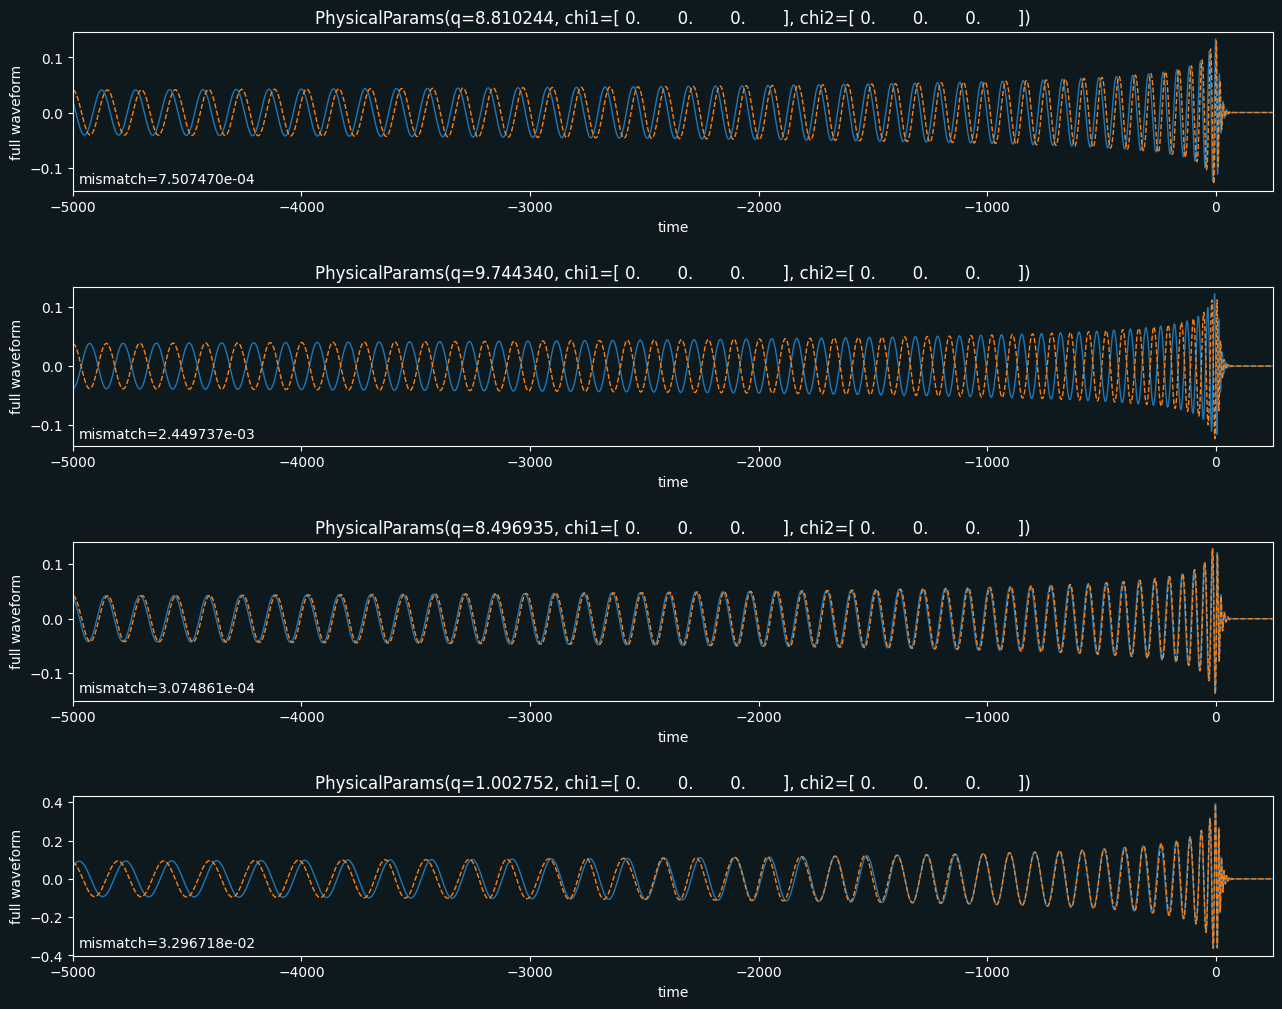

In [11]:
n = 4
random_idxs = np.random.default_rng(seed=42).permutation(len(romgw_waveforms))[:n]

plot_mismatch(
    FullWaveformDataset([fiducial_waveforms[i] for i in random_idxs]),
    FullWaveformDataset([romgw_waveforms[i] for i in random_idxs]),
    # component="phase"
)